### Directional derivatives

Define the directional derivative in a simple 2D example (easy to generalize to the D-dimensional case).

Let $v$ be a unit vector for the direction of the directional derivative, then $d$ is the directional derivative given by

$\begin{align}
d = v_x \frac{\partial f}{\partial x} + v_y \frac{\partial f}{\partial y}
\end{align}$

Let's look at the covariance between $f$ and $d$

$\begin{align}
\text{cov}\left[f, d\right] &= \text{cov}\left[f, v_x \frac{\partial f}{\partial x} + v_y \frac{\partial f}{\partial y}\right] \\
&= v_x \text{cov}\left[f, \frac{\partial f}{\partial x}\right] + v_y\text{cov}\left[f,  \frac{\partial f}{\partial y}\right]
\end{align}$

and the covariance between $d$ and $d$

$\begin{align}
\text{cov}\left[d, d\right] &= \text{cov}\left[v_x \frac{\partial f}{\partial x} + v_y \frac{\partial f}{\partial y}, v_x \frac{\partial f}{\partial x} + v_y \frac{\partial f}{\partial y}\right] \\
&= v_x^2  \text{cov}\left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial x}\right] + v_y^2  \text{cov}\left[\frac{\partial f}{\partial y}, \frac{\partial f}{\partial y}\right] + 2v_x v_y \text{cov}\left[\frac{\partial f}{\partial x} , \frac{\partial f}{\partial y}\right]
\end{align}$

### Let's test it

In [2]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb

import GPy

snb.set(font_scale = 1.5)

### Let's create a simple 2D problem with a domain $\left[0, 1\right]^2$ and let's add two derivative observations in one of the corners of the domain (one for each partial derivative)

In [3]:
# create grid for domain
D = 31
xs = np.linspace(0, 1, D)
X, Y = np.meshgrid(xs, xs)
XY = np.column_stack((X.ravel(), Y.ravel()))
N = len(XY)

x = np.zeros((0, 2))
y = np.zeros((0, 1))

xd1 = XY[0, :][None, :]
yd1 = np.ones((1, 1))

xd2 = XY[0, :][None, :]
yd2 = np.ones((1, 1))

sigma = 1e-2
scale = 1.

### Compute posterior dist given one partial derivative obs. (in the x-direction)

Text(0.5,1,'Posterior mean')

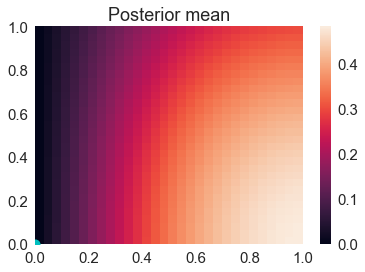

In [18]:
# kernels
se = GPy.kern.RBF(input_dim=2, lengthscale=scale)
se_der1 = GPy.kern.DiffKern(se, 0)

# likelihoods
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=100, fixed=False))

# compute posterior
m = GPy.core.MultioutputGP(X_list=[x, xd1], Y_list=[y, yd1], kernel_list=[se, se_der1], likelihood_list = [gauss, probit, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))
    
# predict
mu_x, Sigma_x = m.predict(np.column_stack((XY, np.zeros((N, 1)))), include_likelihood=False, full_cov=False)
mu_x = mu_x.reshape(D, D)

# plot posterior mean
plt.pcolormesh(xs, xs, mu_x)
plt.plot(xd1[0, 0], xd1[0, 1], 'c.', markersize='20')
plt.colorbar()
plt.title('Posterior mean')

### Compute posterior dist given two partial derivative obs. (one in the x-direction and one in the y-direction)

Text(0.5,1,'Posterior mean')

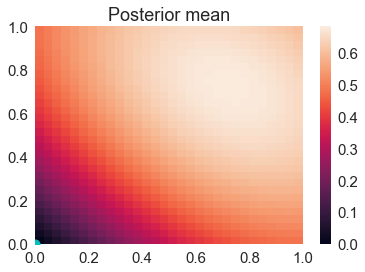

In [17]:
# kernels
se = GPy.kern.RBF(input_dim=2, lengthscale=scale)
se_der1 = GPy.kern.DiffKern(se, 0)
se_der2 = GPy.kern.DiffKern(se, 1)

# likelihoods
gauss = GPy.likelihoods.Gaussian(variance=sigma**2)
probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=100, fixed=False))

# compute posterior
m = GPy.core.MultioutputGP(X_list=[x, xd1, xd2], Y_list=[y, yd1, yd2], kernel_list=[se, se_der1, se_der2], likelihood_list = [gauss, probit, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))
    
# predict
mu_xy, Sigma_xy = m.predict(np.column_stack((XY, np.zeros((N, 1)))), include_likelihood=False, full_cov=False)
mu_xy = mu_xy.reshape(D, D)

# plot posterior mean
plt.pcolormesh(xs, xs, mu_xy)
plt.plot(xd1[0, 0], xd1[0, 1], 'c.', markersize=20)
plt.colorbar()
plt.title('Posterior mean')

### Directional derivative

In [11]:
Xbig, _, index = GPy.util.multioutput.build_XY([XY, xd1, xd2], None)
K = GPy.kern.MultioutputKern([se, se_der1, se_der2]).K(Xbig)

# define direction
v = np.ones(2)
v = v/np.linalg.norm(v)

In [13]:
# auxiliary kernel values
Kfd = v[0] * K[:N, N] + v[1] * K[:N, N+1]
Kdd = v[0]**2*K[N, N] + v[1]**2*K[N+1, N+1] + 2*v[0]*v[1]*K[N, N+1]


In [14]:
from GPy.inference.latent_function_inference.expectation_propagation import EP
from paramz import ObsAr

# compute posterior for the directional derivative
ep = EP()
res = ep.inference(None, XY[0][:, None], probit, ObsAr(np.ones((1, 1))), K=Kdd*np.ones((1, 1)))
mean, cov = res[0].mean, res[0].covariance*np.ones((1,1))

# compute joint kernel
K3 = np.zeros((N + 1, N + 1))
K3[:N, :N] = K[:N, :N]
K3[:N, N] = Kfd
K3[N, :N] = Kfd.T
K3[N, N]=Kdd

# predict f using posterior of the directional derivative
mu_d = np.dot(Kfd[:, None], np.linalg.solve(cov, mean))
mu_d = mu_d.reshape(D, D)

# plot posterior mean
plt.pcolormesh(xs, xs, mu_d)
plt.plot(xd1[0, 0], xd1[0, 1], 'c.', markersize=20)
plt.colorbar()
plt.title('Posterior mean')

### Plot posterior mean for all three cases

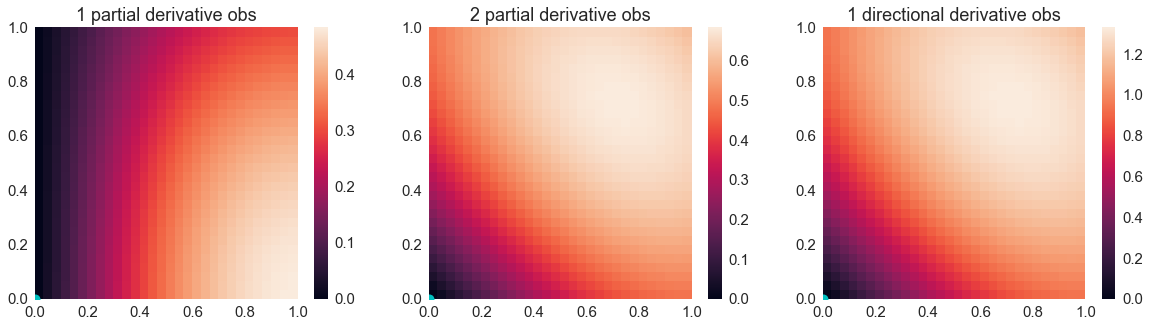

In [19]:
labels = ['1 partial derivative obs', '2 partial derivative obs', '1 directional derivative obs']
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


for val, axi, lab in zip([mu_x, mu_xy, mu_d], ax, labels):
    im = axi.pcolormesh(xs, xs, val)
    axi.set_title(lab)
    plt.colorbar(im, ax=axi)
    axi.plot(xd1[0, 0], xd1[0, 1], 'c.', markersize=20)

In [20]:
3.5*6

21.0